In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
# import glob
# import anndata as ad
# import collections
# from tqdm import tqdm
import argparse


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo') 

In [3]:

name = 'test'
meta = 'naive_B/navieB_seurat_meta.csv'
n_jobs = 36
group = 'subtype'

out_pic1 = name + '_Velocity_pic.pdf'
out_pic2 = name + '_Velocity_Paga_pic.pdf'

# os.chdir('/rd2/user/xiacr/sle/')
# results_file = 'output_file/scvelo/' 
adata =sc.read_h5ad('/rd2/user/xiacr/sle/final/scvelo/all_cell_exclude_berry.h5ad')
cell_meta = pd.read_csv(meta)
cell_meta['1'], cell_meta['2'] = cell_meta['Row.names'].str.split('_', 1).str
cell_meta['barcode'] = cell_meta['1']+ '_' + cell_meta['orig.ident']

# check the cell meta 
if not set(['UMAP_1','UMAP_1','barcode']).issubset(cell_meta.columns):
    # print()
    raise RuntimeError('ERROR: seurat cell meta is not valid, please check it!')

In [4]:
adata_sub = adata[adata.obs['barcode'].isin(cell_meta['barcode'] )]
adata_sub.obs = adata_sub.obs.rename_axis("CellID").reset_index()
adata_sub.obs = adata_sub.obs.merge(cell_meta, how='left', left_on='barcode', right_on='barcode')
adata_sub.obs = adata_sub.obs.set_index('CellID')

In [5]:
del adata
adata_sub

AnnData object with n_obs × n_vars = 9934 × 36601
    obs: 'Clusters', '_X', '_Y', 'batch', 'barcode', 'Unnamed: 0', 'Row.names', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'group', 'treatment', 'pair', 'percent_mito', 'percent_ribo', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.8', 'RNA_snn_res.1', 'seurat_clusters', 'main_type', 'PIC', 'RNA_snn_res.0.6', 'RNA_snn_res.1.2', 'subtype', 'UMAP_1', 'UMAP_2', '1', '2'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [6]:
scv.pp.filter_and_normalize(adata_sub, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata_sub, n_pcs=30, n_neighbors=30)

Filtered out 30622 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:19) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [9]:
scv.tl.recover_dynamics(adata_sub, n_jobs=n_jobs)
scv.tl.velocity(adata_sub, mode='dynamical')
scv.tl.velocity_graph(adata_sub,n_jobs=n_jobs)

recovering dynamics (using 36/40 cores)


  0%|          | 0/153 [00:00<?, ?gene/s]

    finished (0:00:14) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 36/40 cores)


  0%|          | 0/9934 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:02) --> added
    'velocity_harmony', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_test_Velocity_pic.pdf


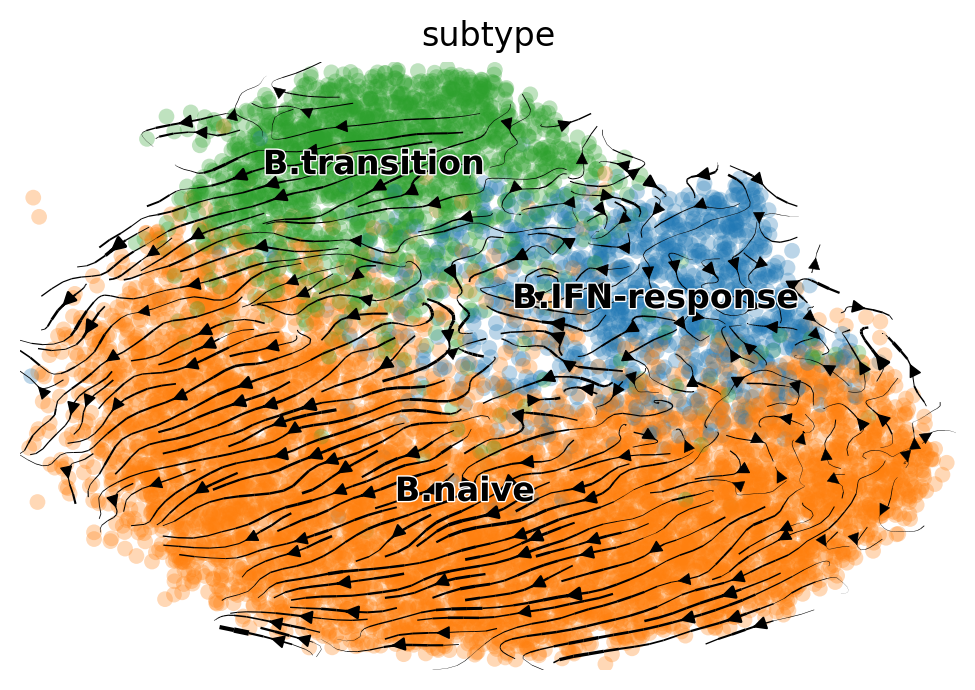

In [10]:
adata_sub.obsm['X_harmony'] =  adata_sub.obs[['UMAP_1','UMAP_2']].to_numpy()
scv.pl.velocity_embedding_stream(adata_sub, basis='harmony',color=group,
                                 save= out_pic1)

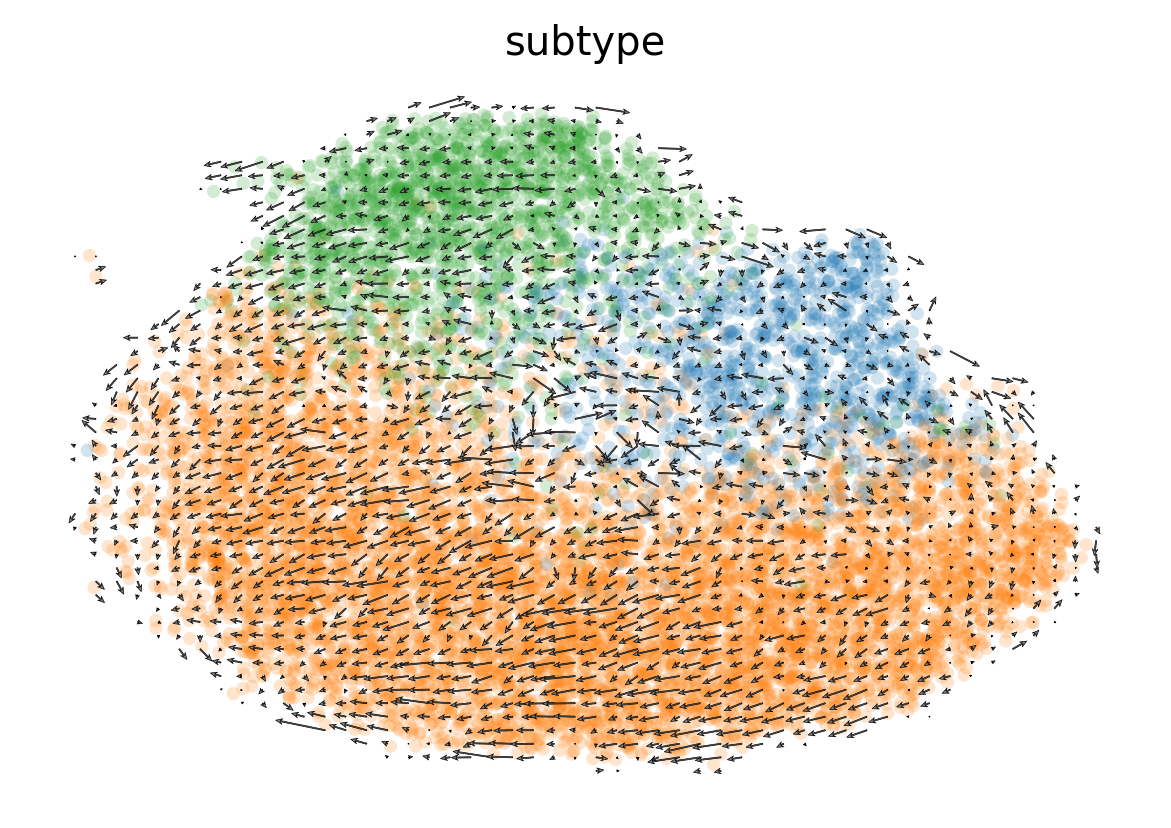

In [23]:
# scv.pl.velocity_embedding(adata_sub, arrow_length=4, arrow_size=1, dpi=200,basis='harmony')
scv.pl.velocity_embedding_grid(adata_sub, dpi=120,color=group, basis='harmony',scale=0.05, arrow_length =3)